**K-MEANS CLUSTERING**

Goal: The goal is to segment telecom customers into groups using clustering based on features that define their behavior, such as monthly charges, tenure, and churn status. This segmentation will help identify customer types, churn prediction, and business insights.

COLUMNS:
1.TENURE
2.MONTHLY CHARGES
3.TOTAL CHARGES
4.CHURN

LOADING AND PREPROCESS THE DATA:


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('TELECOMKMEANS').getOrCreate()

In [ ]:
df = spark.read.csv("/content/processed_telco_customer_churn.csv", header=True, inferSchema=True)
df.show(5)

+----------+------+-------------+------+--------------+------------+-----+-----------+--------------+----------------+------------------------------+-----------------+---------------------------+------------------+----------------------------------+------------------+--------------------------------+----------------+------------------------------------+--------------------+-------------------------------+---------------+-------------------------------+---------------+-----------------------------------+-------------------+-----------------+-----------------+--------------------+-------------------------------------+------------------------------+--------------------------+
|customerID|gender|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|Churn|Partner_Yes|Dependents_Yes|PhoneService_Yes|MultipleLines_No phone service|MultipleLines_Yes|InternetService_Fiber optic|InternetService_No|OnlineSecurity_No internet service|OnlineSecurity_Yes|OnlineBackup_No internet service|OnlineBackup_Yes|

DATA PREPROCESSING


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler


#select features for clustering
df=df.select('tenure','monthlycharges','totalcharges','churn')
df.show(5)

+------+--------------+------------+-----+
|tenure|monthlycharges|totalcharges|churn|
+------+--------------+------------+-----+
|     1|         29.85|       29.85|    0|
|    34|         56.95|      1889.5|    0|
|     2|         53.85|      108.15|    1|
|    45|          42.3|     1840.75|    0|
|     2|          70.7|      151.65|    1|
+------+--------------+------------+-----+
only showing top 5 rows



In [ ]:
#handle missing values
df=df.dropna()

In [ ]:
#combine the features into a single vector(required by K-means)

assembler = VectorAssembler(inputCols=['tenure','monthlycharges','totalcharges'],outputCol='features')
df=assembler.transform(df)
df.show(5)

+------+--------------+------------+-----+-------------------+
|tenure|monthlycharges|totalcharges|churn|           features|
+------+--------------+------------+-----+-------------------+
|     1|         29.85|       29.85|    0|  [1.0,29.85,29.85]|
|    34|         56.95|      1889.5|    0|[34.0,56.95,1889.5]|
|     2|         53.85|      108.15|    1| [2.0,53.85,108.15]|
|    45|          42.3|     1840.75|    0|[45.0,42.3,1840.75]|
|     2|          70.7|      151.65|    1|  [2.0,70.7,151.65]|
+------+--------------+------------+-----+-------------------+
only showing top 5 rows



In [ ]:
#standardise the features
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)
df.show(5)

+------+--------------+------------+-----+-------------------+--------------------+
|tenure|monthlycharges|totalcharges|churn|           features|     scaled_features|
+------+--------------+------------+-----+-------------------+--------------------+
|     1|         29.85|       29.85|    0|  [1.0,29.85,29.85]|[0.04074106413396...|
|    34|         56.95|      1889.5|    0|[34.0,56.95,1889.5]|[1.38519618055491...|
|     2|         53.85|      108.15|    1| [2.0,53.85,108.15]|[0.08148212826793...|
|    45|          42.3|     1840.75|    0|[45.0,42.3,1840.75]|[1.83334788602857...|
|     2|          70.7|      151.65|    1|  [2.0,70.7,151.65]|[0.08148212826793...|
+------+--------------+------------+-----+-------------------+--------------------+
only showing top 5 rows



**K-MEANS CLUSTERING**


1.Apply K-means clustering

In [ ]:
from pyspark.ml.clustering import KMeans

#perform k-means clustering
Kmeans = KMeans().setK(3).setSeed(1)
model =Kmeans.fit(df)

In [ ]:
#making predictions
predictions = model.transform(df)

#showing the results
predictions.select( "tenure", "MonthlyCharges", "TotalCharges", "prediction").show(5)

+------+--------------+------------+----------+
|tenure|MonthlyCharges|TotalCharges|prediction|
+------+--------------+------------+----------+
|     1|         29.85|       29.85|         0|
|    34|         56.95|      1889.5|         0|
|     2|         53.85|      108.15|         0|
|    45|          42.3|     1840.75|         0|
|     2|          70.7|      151.65|         0|
+------+--------------+------------+----------+
only showing top 5 rows



Evalute the optimal number of clusters(k):

In [ ]:
import time
from pyspark.ml.evaluation import ClusteringEvaluator
cost = []
for k in range(2, 10):
    # Record the start time
    start_time = time.time()

    # KMeans clustering
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df)
    predictions = model.transform(df)

    # Evaluate the cost
    evaluator = ClusteringEvaluator()
    cost_value = evaluator.evaluate(predictions)
    cost.append(cost_value)

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    # Print the results
    print(f"Cost for K={k}: {cost_value}, Time taken: {time_taken} seconds")



Cost for K=2: 0.8480065850556017, Time taken: 3.9186642169952393 seconds
Cost for K=3: 0.7991926731721976, Time taken: 3.8459811210632324 seconds
Cost for K=4: 0.7544562353637503, Time taken: 3.7195873260498047 seconds
Cost for K=5: 0.7530520950994757, Time taken: 4.648106575012207 seconds
Cost for K=6: 0.7525647455394332, Time taken: 3.5340263843536377 seconds
Cost for K=7: 0.7437739859323019, Time taken: 3.7886219024658203 seconds
Cost for K=8: 0.7315236040887104, Time taken: 5.038800001144409 seconds
Cost for K=9: 0.7184880760390671, Time taken: 3.5455710887908936 seconds


Analyze clusters:

In [ ]:
predictions.groupby('prediction').mean("tenure","monthlycharges","totalcharges").show()

+----------+------------------+-------------------+------------------+
|prediction|       avg(tenure)|avg(monthlycharges)| avg(totalcharges)|
+----------+------------------+-------------------+------------------+
|         1| 69.95652173913044| 109.50170807453424| 7673.539751552793|
|         6| 65.65658747300216|  97.41565874730027| 6371.540712742975|
|         3| 59.19962335216572|  89.80932203389827| 5218.577401129941|
|         5| 52.32897196261682|  81.84682242990657| 4124.808130841119|
|         4| 4.828848223896663|  46.41805705059196| 167.3465016146392|
|         8| 20.44840182648402|   50.3970319634703| 719.2348401826484|
|         7| 36.62229102167183|  52.35252837977296|1358.5074303405597|
|         2|42.723958333333336|  77.08177083333345|3099.5309895833325|
|         0| 35.39531478770132|  69.19912152269406| 2133.547730600293|
+----------+------------------+-------------------+------------------+



In [ ]:
predictions.groupby('prediction').agg(
    {'tenure': 'mean', 'monthlycharges': 'mean', 'totalcharges': 'mean'}
).show()


+----------+------------------+-------------------+------------------+
|prediction| avg(totalcharges)|avg(monthlycharges)|       avg(tenure)|
+----------+------------------+-------------------+------------------+
|         1| 7673.539751552793| 109.50170807453424| 69.95652173913044|
|         6| 6371.540712742975|  97.41565874730027| 65.65658747300216|
|         3| 5218.577401129941|  89.80932203389827| 59.19962335216572|
|         5| 4124.808130841119|  81.84682242990657| 52.32897196261682|
|         4| 167.3465016146392|  46.41805705059196| 4.828848223896663|
|         8| 719.2348401826484|   50.3970319634703| 20.44840182648402|
|         7|1358.5074303405597|  52.35252837977296| 36.62229102167183|
|         2|3099.5309895833325|  77.08177083333345|42.723958333333336|
|         0| 2133.547730600293|  69.19912152269406| 35.39531478770132|
+----------+------------------+-------------------+------------------+



In [ ]:
predictions.groupby('prediction',"churn").count().show()

+----------+-----+-----+
|prediction|churn|count|
+----------+-----+-----+
|         1|    0|  290|
|         6|    1|   65|
|         3|    1|   86|
|         7|    1|  214|
|         6|    0|  398|
|         4|    0| 1068|
|         1|    1|   32|
|         0|    0|  513|
|         8|    1|  287|
|         2|    1|  137|
|         2|    0|  439|
|         0|    1|  170|
|         5|    0|  447|
|         8|    0|  808|
|         5|    1|   88|
|         3|    0|  445|
|         4|    1|  790|
|         7|    0|  755|
+----------+-----+-----+



In [ ]:

start_time = time.time()
model = kmeans.fit(df)
end_time = time.time()
print(f"Time taken for clustering: {end_time - start_time} seconds")


Time taken for clustering: 3.899782419204712 seconds


VISUALIZING CLUSTERS

In [ ]:
import plotly.express as px

# Convert the predictions DataFrame to pandas for easier plotting
df_pandas = predictions.toPandas()

# Create a 3D scatter plot using plotly
fig = px.scatter_3d(df_pandas,
                    x='tenure',
                    y='monthlycharges',
                    z='totalcharges',
                    color='prediction',   # color by prediction (cluster label)
                    title="3D Scatter Plot of Telecom Customer Clusters",
                    labels={'tenure': 'Tenure', 'monthlycharges': 'Monthly Charges', 'totalcharges': 'Total Charges'},
                    color_continuous_scale='Viridis')  # You can choose other color scales like 'Plasma', 'Cividis', etc.

# Show the interactive plot
fig.show()


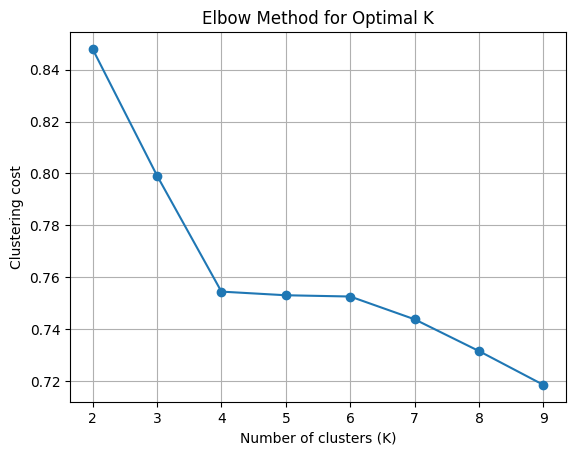

In [ ]:
import matplotlib.pyplot as plt

# Elbow plot to visualize the cost for different values of K
plt.plot(range(2, 10), cost, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Clustering cost')
plt.grid(True)
plt.show()


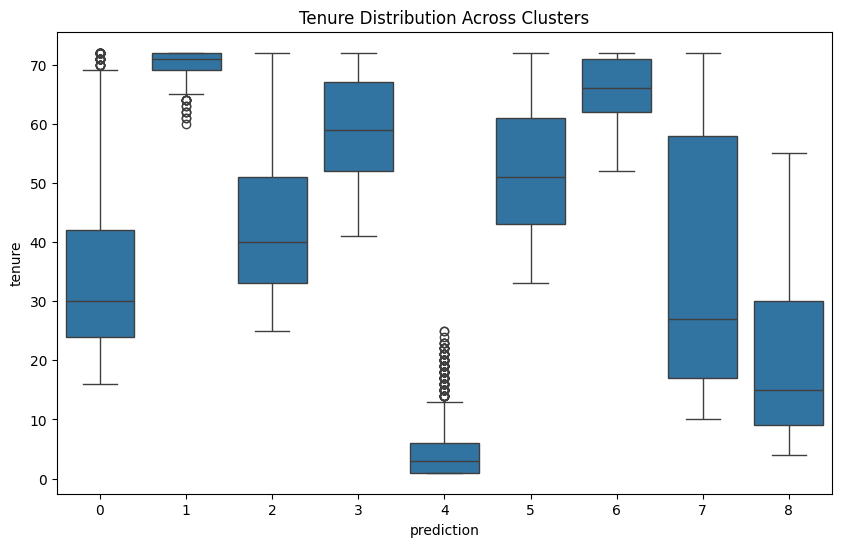

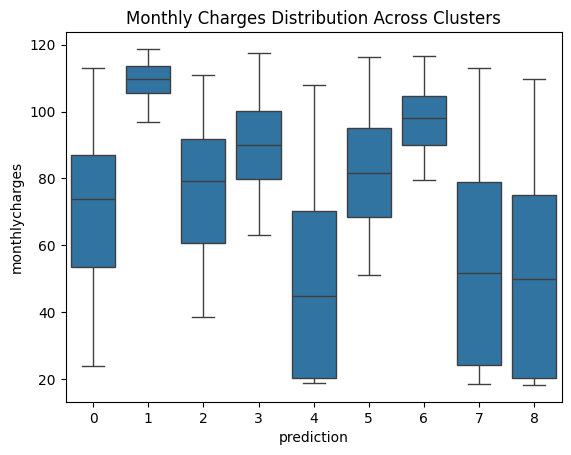

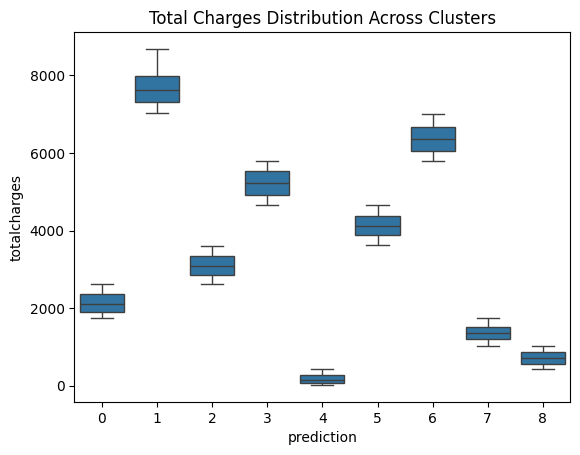

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))

# Boxplot for 'tenure'
sns.boxplot(x='prediction', y='tenure', data=df_pandas)
plt.title('Tenure Distribution Across Clusters')
plt.show()

# Boxplot for 'monthlycharges'
sns.boxplot(x='prediction', y='monthlycharges', data=df_pandas)
plt.title('Monthly Charges Distribution Across Clusters')
plt.show()

# Boxplot for 'totalcharges'
sns.boxplot(x='prediction', y='totalcharges', data=df_pandas)
plt.title('Total Charges Distribution Across Clusters')
plt.show()
